# Table of Contents

1. Importing Libraries
2. Importing Dataset
3. Data Preprocessing
4. Exploratory Data Analysis
5. Feature Engineering and Selection
6. Model Selection
7. Submission
8. Conclusion

# Importing Libraries

In [1]:
# Packages for data analysis
import pandas as pd
import numpy as np
import time

# Packages for visualizations
import seaborn as sns
import matplotlib.style as style

# Packages for preprocessing
import nltk
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Packages for training models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import xgboost as xgb

# Model Evaluation Packages
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
%matplotlib inline

# Style
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')


# Importing Dataset

In [2]:
# Importing the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Data Preprocessing

In [3]:
# Looking at the first few entries in the dataset
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
# Print the first few entries in the dataset
print(train['message'].head())

0    PolySciMajor EPA chief doesn't think carbon di...
1    It's not like we lack evidence of anthropogeni...
2    RT @RawStory: Researchers say we have three ye...
3    #TodayinMaker# WIRED : 2016 was a pivotal year...
4    RT @SoyNovioDeTodas: It's 2016, and a racist, ...
Name: message, dtype: object


In [5]:
# Looking at the first few entries in the dataset
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [6]:
# Looking at the predicted output
sample_submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [7]:
# Looking at the how tweetid are distributed across sentiment
train.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


In [8]:
# Taking general overview at both datasets
print('TRAINING DATA')
print('============='+('\n'))
print('Shape of the dataset: {}\n'.format(train.shape))
print('Total Number of unique tweets: {}\n'.format(len(set(train['message']))))
print('Total Number of missing values:\n{}\n\n'.format(train.isnull().sum()))
print('TEST DATA')
print('========='+('\n'))
print('Shape of the dataset: {}\n'.format(test.shape))
print('Total Number of unique tweets: {}\n'.format(len(set(test['message']))))
print('Total Number of missing values:\n{}\n' .format(test.isnull().sum()))


TRAINING DATA

Shape of the dataset: (15819, 3)

Total Number of unique tweets: 14229

Total Number of missing values:
sentiment    0
message      0
tweetid      0
dtype: int64


TEST DATA

Shape of the dataset: (10546, 2)

Total Number of unique tweets: 9575

Total Number of missing values:
message    0
tweetid    0
dtype: int64



# Exploratory Data Analysis

In [9]:
# Checking whether a character is white-space character or not
print(len(train['message']))
print(sum(train['message'].apply(lambda x: x.isspace())))

15819
0


Text(0.5, 1.0, 'Distribution of target labels')

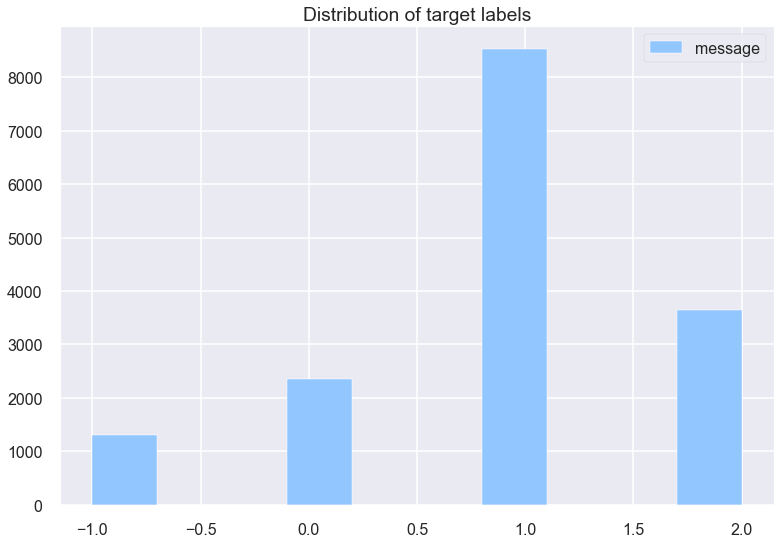

In [10]:
# Visualizing the distribution of the target 
plt.hist(train['sentiment'], label='message');
plt.legend();
plt.title('Distribution of target labels')

## Data Cleaning

In [11]:
def cleaner(line):
    '''
    For preprocessing the data, we regularize, transform each upper case into lower case, tokenize,
    normalize and remove stopwords. Normalization transforms a token to its root word i.e. 
    These words would be transformed from "love loving loved" to "love love love."
    
    '''

    # Removes RT, url and trailing white spaces
    line = re.sub(r'^RT ','', re.sub(r'https://t.co/\w+', '', line).strip()) 

    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # removes emoticons,
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    line = emojis.sub(r'', line)

    
    # Removes puctuation
    punctuation = re.compile("[.;:!\'’‘“”?,\"()\[\]]")
    message = punctuation.sub("", line.lower()) 

    # Removes stopwords
    nlp_for_stopwords = NLP(replace_words=True, remove_stopwords=True, 
                            remove_numbers=True, remove_punctuations=False) 
    message = nlp_for_stopwords.process(message) # This will remove stops words that are not necessary. The idea is to keep words like [is, not, was]
    # https://towardsdatascience.com/why-you-should-avoid-removing-stopwords-aa7a353d2a52
    # print("After removing stopwords:\n", message, '\n'*2)

    # tokenisation
    # We used the split method instead of the word_tokenise library because our message is already clean at this point
    # and the twitter data is not complicated
    message = message.split() 

    # POS 
    # Part of Speech tagging is essential to ensure Lemmatization perfoms well.
    pos = pos_tag(message)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    message = ' '.join([lemmatizer.lemmatize(word, po[0].lower()) 
                      if (po[0].lower() in ['n', 'r', 'v', 'a'] and word[0] != '@') else word for word, po in pos])

    return message

In [12]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import InstanceHardnessThreshold
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

iht = InstanceHardnessThreshold(random_state=42)
X_res, y_res = iht.fit_resample(X, y)

# Feature Engineering and Selection

In [13]:
# Splitting out X (indepedent) and Y (target/dependent) variables
X_res = train['message']
y_res = train['sentiment']

In [14]:
# Splitting of Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.01, random_state=42)

# Model Selection

## Setting up Classifiers for Model Training

In [15]:
# List all the models

classifiers = [LinearSVC(random_state=42),
                SVC(),
                DecisionTreeClassifier(),
                RandomForestClassifier(n_estimators=100, max_depth=2,
                                     random_state=0, class_weight="balanced"),
                MLPClassifier(alpha=1e-5,
                             hidden_layer_sizes=(5, 2),
                             random_state=42),
                LogisticRegression(random_state=5,
                                  multi_class='ovr',
                                  n_jobs=1,
                                  C=1
                                  ),
                KNeighborsClassifier(n_neighbors=5),
                MultinomialNB(),
                ComplementNB(),
                SGDClassifier(loss='hinge',
                             penalty='l2',
                             alpha=1e-3,
                             random_state=42,
                             max_iter=5,
                             tol=None)
               ]


In [16]:
# Creating Function for Model Building

def models_building(classifiers, X_train, y_train, X_val, y_val):
    """
    This function takes in a list of classifiers
    and both the train and validation sets
    and return a summary of F1-score and
    processing time as a dataframe

    Input:
    classifiers: a list of classifiers to train
                 datatype: list
    X_train: independent variable for training
             datatype: series
    y_train: dependent variable for training
             datatype: series
    X_val: independent variable for validation
           datatype: series
    y_val: dependent variable for validation
           datatype: series

    Output:
    model_summary: F1 Score for all the classifiers
                   datatype: dataframe
    """

    models_summary = {}

    # Pipeline to balance the classses and then to build the model
    for clf in classifiers:
        clf_text = Pipeline([('tfidf', TfidfVectorizer(min_df=2,
                                                       max_df=0.95,
                                                       ngram_range=(1, 2),
                                                       analyzer='word')),
                             ('clf', clf)])

        # Logging the Execution Time for each model
        start_time = time.time()
        clf_text.fit(X_train, y_train)
        predictions = clf_text.predict(X_val)
        run_time = time.time()-start_time

        # Output for each model
        models_summary[clf.__class__.__name__] = {
            'F1-Macro': metrics.f1_score(y_val,
                                         predictions,
                                         average='macro'),
            'F1-Accuracy': metrics.f1_score(y_val, predictions,
                                            average='micro'),
            'F1-Weighted': metrics.f1_score(y_val,
                                            predictions,
                                            average='weighted'),
            'Execution Time': run_time}

    return pd.DataFrame.from_dict(models_summary, orient='index')


In [17]:
# Execution of the Classifiers

classifiers_df = models_building(classifiers, X_train, y_train, X_val, y_val)
ordered_df = classifiers_df.sort_values('F1-Macro', ascending=False)
ordered_df


,F1-Macro,F1-Accuracy,F1-Weighted,Execution Time
LinearSVC,0.744533,0.798742,0.792909,1.961999
ComplementNB,0.667822,0.761006,0.743122,1.078050
KNeighborsClassifier,0.666610,0.698113,0.700713,1.374901
SVC,0.655616,0.761006,0.736107,165.883244
LogisticRegression,0.632623,0.767296,0.738822,3.687244
DecisionTreeClassifier,0.593364,0.647799,0.644714,7.921611
SGDClassifier,0.440210,0.672956,0.609118,1.203032
MultinomialNB,0.437151,0.691824,0.613552,0.999933
RandomForestClassifier,0.434013,0.490566,0.497120,1.312401
MLPClassifier,0.383137,0.679245,0.589662,144.679016


## Hyperparameter Tuning on Most Performing Models

In [18]:
# Refining the train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.01, random_state=42)

### Multinomial Naive Bayes

In [19]:
# MultiNB Gridsearch
param_grid = {'alpha': [0.1, 1, 5, 10, 20]}  # setting parameter grid

HP_MNB = Pipeline([('tfidf', TfidfVectorizer(min_df=2,
                                                max_df=0.95,
                                                ngram_range=(1, 2),
                                                analyzer='word')),
                      ('mnb', GridSearchCV(MultinomialNB(),
                                           param_grid=param_grid,
                                           cv=5,
                                           n_jobs=-1,
                                           scoring='f1_weighted'))
                      ])

HP_MNB.fit(X_train, y_train)  # Fitting the model

y_pred_mnb = HP_MNB.predict(X_val)  # predicting the fit on validation set

print(classification_report(y_val, y_pred_mnb))
print('F1_score: ',round(metrics.f1_score(y_val, y_pred_mnb, average = 'weighted'),5))

              precision    recall  f1-score   support

          -1       1.00      0.50      0.67        10
           0       0.77      0.37      0.50        27
           1       0.76      0.89      0.82        92
           2       0.76      0.83      0.79        30

    accuracy                           0.77       159
   macro avg       0.82      0.65      0.70       159
weighted avg       0.78      0.77      0.75       159

F1_score:  0.75105


In [24]:
# SVC linear Gridsearch
vect=TfidfVectorizer(min_df=2,max_df=0.95,ngram_range=(1, 2),analyzer='word')
X_train_tfidf=vect.fit_transform(X_train)
X_val_tfidf=vect.transform(X_val)

parameters = {'kernel':['linear'],
              'C':[0.25,1.0],
              'gamma': [1,2]}

                   
SVCrbf = SVC()
SVC_clf = GridSearchCV(SVCrbf, parameters)
SVC_clf.fit(X_train_tfidf,y_train) # fitting the model
y_pred_svc = SVC_clf.predict(X_val_tfidf)  # predicting the fit on validation set

print(classification_report(y_val, y_pred_svc))
print('F1_score: ',round(metrics.f1_score(y_val, y_pred_svc, average = 'weighted'),5))

              precision    recall  f1-score   support

          -1       1.00      0.60      0.75        10
           0       0.81      0.48      0.60        27
           1       0.81      0.89      0.85        92
           2       0.72      0.87      0.79        30

    accuracy                           0.80       159
   macro avg       0.84      0.71      0.75       159
weighted avg       0.81      0.80      0.79       159

F1_score:  0.79018


# Submission

In [20]:
submission = pd.DataFrame(test['tweetid'])
submission['sentiment'] = HP_MNB.predict(test['message'])
submission.to_csv('MNB.csv', index=False)

In [27]:
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [25]:
submission = pd.DataFrame(test['tweetid'])
submission['sentiment'] = HP_MNB.predict(test['message'])
submission.to_csv('SVC_clf.csv', index=False)

In [26]:
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


# Conclusion